In [1]:
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
def crop_image_from_gray(img,tol=7):
    
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        mask = gray_img>tol        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0):
            return img
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
            img = np.stack([img1,img2,img3],axis=-1)
        return img

In [3]:
def circle_crop_v2(img):
    """
    Create circular crop around image centre
    """

    img = crop_image_from_gray(img)

    height, width, depth = img.shape
    largest_side = np.max((height, width))
    img = cv2.resize(img, (largest_side, largest_side))

    height, width, depth = img.shape

    x = int(width / 2)
    y = int(height / 2)
    r = np.amin((x, y))

    circle_img = np.zeros((height, width), np.uint8)
    cv2.circle(circle_img, (x, y), int(r), 1, thickness=-1)
    img = cv2.bitwise_and(img, img, mask=circle_img)
    img = crop_image_from_gray(img)

    return img

In [4]:
img = cv2.imread('DR/train2/0f96c358a250.png')
#0f96c358a250 10eefba568dd
img = cv2.resize(img, (768,576))

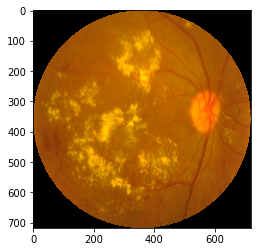

In [5]:
img = circle_crop_v2(img)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img,cmap='gray')

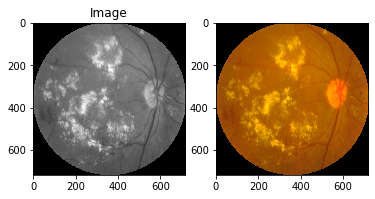

Text(0.5, 1, 'Histogram')

In [6]:
green_image = img[:,:,1]
hist = cv2.calcHist([green_image],[0],None,[256],[0,256])

fig = plt.figure()
a = fig.add_subplot(1, 2, 1)
imgplot = plt.imshow(green_image,cmap='gray')
a.set_title('Image')

a = fig.add_subplot(1, 2, 2)
#plt.hist(green_image.ravel(),256,[0,256])
plt.imshow(img)
imgplot = plt.show()
a.set_title('Histogram')

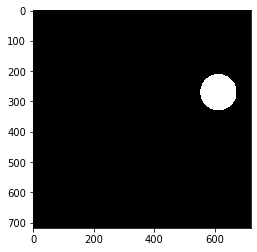

In [7]:
cl=green_image

xc, yc, r = 610,270,60
# size of the image
H, W = cl.shape
# x and y coordinates per every pixel of the image
x, y = np.meshgrid(np.arange(W), np.arange(H))
# squared distance from the center of the circle
d2 = (x - xc)**2 + (y - yc)**2
# mask is True inside of the circle
mask = d2 < r**2
plt.imshow(mask,cmap='gray')

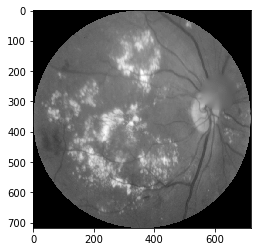

In [8]:
bytemask = np.asarray(mask*255, dtype=np.uint8)
inpainted = cv2.inpaint(cl, bytemask, inpaintRadius=60, flags=cv2.INPAINT_TELEA)
plt.imshow(inpainted,cmap='gray')

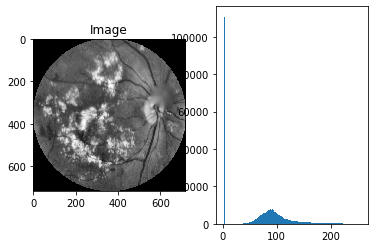

Text(0.5, 1, 'Histogram')

In [9]:
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
cl = clahe.apply(inpainted)

fig = plt.figure()
a = fig.add_subplot(1, 2, 1)
imgplot = plt.imshow(cl,cmap='gray')
a.set_title('Image')


a = fig.add_subplot(1, 2, 2)
plt.hist(cl.ravel(),256,[0,256])
imgplot = plt.show()
a.set_title('Histogram')

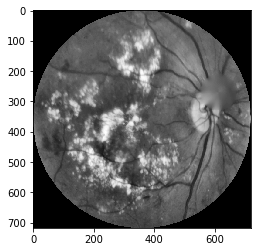

In [10]:
median = cv2.medianBlur(cl, 3)
plt.imshow(median,cmap='gray')

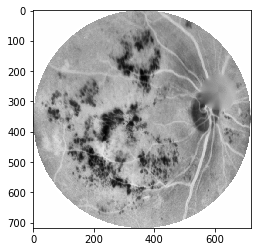

In [11]:
thresh = cv2.adaptiveThreshold(median,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,13,0.042)
thresh = thresh-cl
plt.imshow(thresh,cmap='gray')

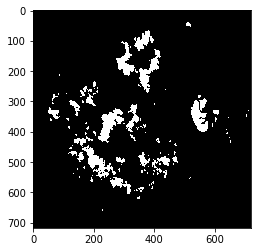

In [12]:
ret,img = cv2.threshold(thresh,100,255,cv2.THRESH_BINARY_INV)
plt.imshow(img,cmap='gray')

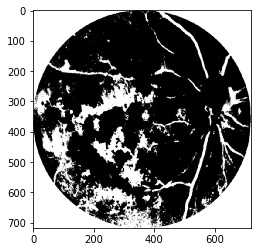

In [13]:
ret,img1 = cv2.threshold(thresh,180,255,cv2.THRESH_BINARY)
img2 = cv2.GaussianBlur(img1,(5,5),0)
plt.imshow(img2,cmap='gray')

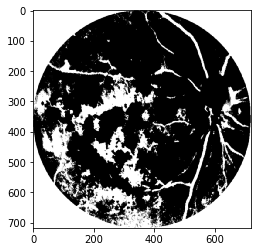

In [14]:
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
op = cv2.morphologyEx(img2, cv2.MORPH_CLOSE, kernel)
plt.imshow(op,cmap='gray')

In [15]:
contours, hierarchy = cv2.findContours(op, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

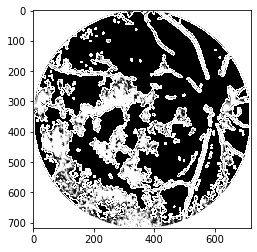

In [16]:
cv2.drawContours(op, contours, -1, (255,0,0), 3)
plt.imshow(op,cmap='gray')

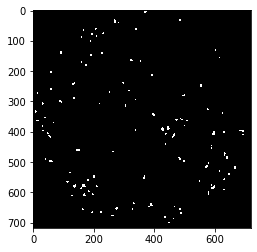

In [17]:
mask = np.ones(op.shape[:2], dtype="uint8") * 0
for cnt in contours:
    #print(cv2.contourArea(cnt))
    if cv2.contourArea(cnt)>= 10 and cv2.contourArea(cnt)<=100:
        cv2.drawContours(mask, [cnt], -1, 255, -1)
plt.imshow(mask,cmap='gray')